# grape-disease-classification

**Author: Alex Lim**

## Mount Google Drive

In [127]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/workspace/grape-disease-classification

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/workspace/grape-disease-classification


## Check NVIDIA GPU Info

In [0]:
!nvidia-smi

Sat Apr 27 21:05:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6866834836029653923, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2856210626362762635
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6510043562174901757
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800630580
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5761602355602274153
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## Import Packages

In [128]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import cv2
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(100)
np.random.seed(100)
tf.set_random_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 1.13.1
Keras version: 2.2.4-tf


## Define Directory Paths

Our dataset has to be organized in a certain way so that we can leverage Keras' ```ImageDataGenerator``` The directory tree for our dataset should follow a similar format as the image below.

<p align='center'>
  ![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
</p>

Source: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [0]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')
data_arr_dir = os.path.join(work_dir, 'data_arr')
model_dir = os.path.join(work_dir, 'saved_models')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [0]:
os.mkdir(data_dir)
os.mkdir(data_arr)
os.mkdir(model_dir)

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

os.mkdir(train_black_measles_dir)
os.mkdir(train_black_rot_dir)
os.mkdir(train_leaf_blight_dir)
os.mkdir(train_healthy_dir)

os.mkdir(validation_black_measles_dir)
os.mkdir(validation_black_rot_dir)
os.mkdir(validation_leaf_blight_dir)
os.mkdir(validation_healthy_dir)

os.mkdir(test_black_measles_dir)
os.mkdir(test_black_rot_dir)
os.mkdir(test_leaf_blight_dir)
os.mkdir(test_healthy_dir)

## Construct Dataset

### Observe Number of Images Per Class

In [130]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('healthy class has {} images'.format(num_healthy))

Total Images: 4062
black_measles class has 1383 images
black_rot class has 1180 images
leaf_blight class has 1076 images
healthy class has 423 images


In [131]:
pct_black_measles = (num_black_measles / total_images) * 100.0
pct_black_rot = (num_black_rot / total_images) * 100.0
pct_leaf_blight = (num_leaf_blight / total_images) * 100.0
pct_healthy = (num_healthy / total_images) * 100.0

print('Percentage of black_measles class: {:.2f}%'.format(pct_black_measles))
print('Percentage of black_rot class: {:.2f}%'.format(pct_black_rot))
print('Percentage of leaf_blight class: {:.2f}%'.format(pct_leaf_blight))
print('Percentage of healthy class: {:.2f}%'.format(pct_healthy))

Percentage of black_measles class: 34.05%
Percentage of black_rot class: 29.05%
Percentage of leaf_blight class: 26.49%
Percentage of healthy class: 10.41%


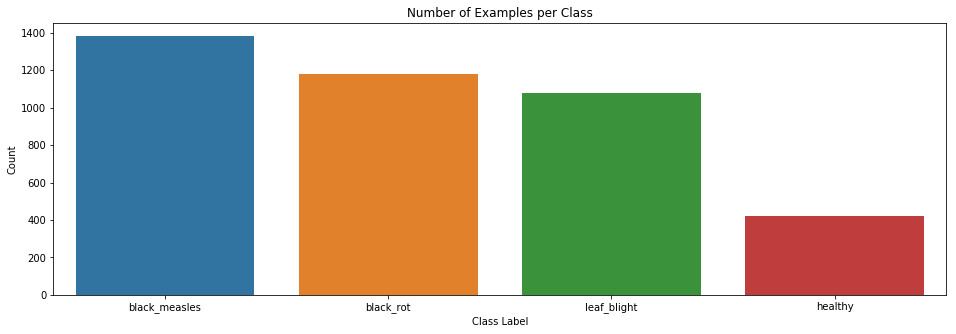

In [132]:
data_dist = pd.DataFrame.from_dict(data={ 'black_measles': [num_black_measles],
                                          'black_rot': [num_black_rot],
                                          'leaf_blight': [num_leaf_blight],
                                          'healthy': [num_healthy] } )
sns.barplot(data=data_dist);
plt.xlabel('Class Label');
plt.ylabel('Count');
plt.title('Number of Examples per Class');

We see that we have a fairly imbalanced dataset (as in the case for the healthy class). However, we will consider this later in our analysis.

### Rename Image Files

The file names for each image is for the most part uninterpretable (e.g., 0a4403ee-995a-4dbd-add7-f13bf17e15dd___FAM_B.Msls 4248). We will first rename all the image names to something more interpretable.

In [0]:
def rename_images(path, class_name):
  """
  Helper function to rename all images inside a directory to a standard
  naming scheme.
  @param path - the path to the image directory
  @param class_name - the name of the class
  """
  for i, image in enumerate(os.listdir(path)):
    new_name = class_name + str(i) + '.jpg'
    src = os.path.join(path, image)
    dst = os.path.join(path, new_name)
    os.rename(src, dst)
  print('Finished renaming all images.')

In [0]:
# Rename all images
rename_images(black_measles_dir, class_name='black_measles')
rename_images(black_rot_dir, class_name='black_rot')
rename_images(leaf_blight_dir, class_name='leaf_blight')
rename_images(healthy_dir, class_name='healthy')

Finished renaming all images.
Finished renaming all images.
Finished renaming all images.
Finished renaming all images.


In [0]:
# Confirm
print(os.listdir(black_measles_dir)[:5])
print(os.listdir(black_rot_dir)[:10])
print(os.listdir(leaf_blight_dir)[:10])
print(os.listdir(healthy_dir)[:10])

['black_measles0.jpg', 'black_measles1.jpg', 'black_measles2.jpg', 'black_measles3.jpg', 'black_measles4.jpg']
['black_rot0.jpg', 'black_rot1.jpg', 'black_rot2.jpg', 'black_rot3.jpg', 'black_rot4.jpg', 'black_rot5.jpg', 'black_rot6.jpg', 'black_rot7.jpg', 'black_rot8.jpg', 'black_rot9.jpg']
['leaf_blight0.jpg', 'leaf_blight1.jpg', 'leaf_blight2.jpg', 'leaf_blight3.jpg', 'leaf_blight4.jpg', 'leaf_blight5.jpg', 'leaf_blight6.jpg', 'leaf_blight7.jpg', 'leaf_blight8.jpg', 'leaf_blight9.jpg']
['healthy0.jpg', 'healthy1.jpg', 'healthy2.jpg', 'healthy3.jpg', 'healthy4.jpg', 'healthy5.jpg', 'healthy6.jpg', 'healthy7.jpg', 'healthy8.jpg', 'healthy9.jpg']


### Shuffle and Train-Validation-Test Split

We will not split our dataset into train, validation, and test sets. First we will randomize the images and apply a stratified split to consider the distribution of the dataset. 

We will allocate 80% for training and 20% for test. Then we will split the training set into 80% training and 20% validation.

In [0]:
def split_data(data_src, label, test_size=0.2, val_size=0.2):
  '''
  Function to split the original dataset into training, validation, and test
  sets and copies to the respective folders. 
  @param data_src - the path to the data
  @param label - the class label
  @test_size - the percent allocated for test 
  @val_size - the percent allocated for validation (of the training data)
  '''
  assert label in ['black_measles', 'black_rot', 'leaf_blight', 'healthy'], \
    "Make sure class label is correct"
  
  train_dir = os.path.join(data_src, 'train', label)
  val_dir = os.path.join(data_src, 'validation', label)
  test_dir = os.path.join(data_src, 'test', label)
  
  assert len(os.listdir(train_dir)) == 0, "Training directory is not empty."
  assert len(os.listdir(val_dir)) == 0, "Validation directory is not empty."
  assert len(os.listdir(test_dir)) == 0, "Test directory is not empty."
  
  data_path = os.path.join(data_src, label)
  num_examples = len(os.listdir(data_path))
  
  # Shuffle the data
  datafiles = os.listdir(data_path)
  random.shuffle(datafiles)
  
  # Train-test split
  num_test = math.floor(num_examples*0.2)
  num_train = num_examples - num_test
  
  # Train-validation split
  num_val = math.floor(num_train*0.2)
  num_train = num_train - num_val
  
  # Train, validation, and test data
  train_files = datafiles[:num_train]
  val_files = datafiles[num_train:num_train+num_val]
  test_files = datafiles[num_train+num_val:]
    
  # Copy training data
  for filename in train_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(train_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy validation data
  for filename in val_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(val_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy test data
  for filename in test_files:
    src = os.path.join(data_src, label,filename)
    dst = os.path.join(test_dir, filename)
    shutil.copyfile(src, dst)

Using the above function above, we are able to take the image dataset from each label category and split them into training, validation, and test sets with a 80-20 split. Running the code below will partition the dataset in a stratified fashion and copy the images to their respective folders. 

**NOTE: Function below may take a while.**

In [0]:
for label in ['black_measles', 'black_rot', 'leaf_blight', 'healthy']:
  split_data(data_dir, label)

In [135]:
# Sanity check 
num_train_black_measles = len(os.listdir(train_black_measles_dir))
num_train_black_rot = len(os.listdir(train_black_rot_dir))
num_train_leaf_blight = len(os.listdir(train_leaf_blight_dir))
num_train_healthy = len(os.listdir(train_healthy_dir))

num_val_black_measles = len(os.listdir(validation_black_measles_dir))
num_val_black_rot = len(os.listdir(validation_black_rot_dir))
num_val_leaf_blight = len(os.listdir(validation_leaf_blight_dir))
num_val_healthy = len(os.listdir(validation_healthy_dir))

num_test_black_measles = len(os.listdir(test_black_measles_dir))
num_test_black_rot = len(os.listdir(test_black_rot_dir))
num_test_leaf_blight = len(os.listdir(test_leaf_blight_dir))
num_test_healthy = len(os.listdir(test_healthy_dir))

total_train = num_train_black_measles + num_train_black_rot + \
                num_train_leaf_blight + num_train_healthy
total_val = num_val_black_measles + num_val_black_rot + \
              num_val_leaf_blight + num_val_healthy
total_test = num_test_black_measles + num_test_black_rot + \
              num_test_leaf_blight + num_test_healthy

def check_distribution(total, black_measles, black_rot, leaf_blight, healthy):
  print('% of black_measles: {:.2f}%'.format((black_measles/total)*100.0))
  print('% of blacK_rot: {:.2f}%'.format((black_rot / total)*100))
  print('% of leaf_blight: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('% of healthy: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_val + total_test)
print('Total black_measles:', num_train_black_measles+num_val_black_measles+num_test_black_measles)
print('Total blacK_rot:', num_train_black_rot+num_val_black_rot+num_test_black_rot)
print('Total leaf_blight:', num_train_leaf_blight+num_val_leaf_blight+num_test_leaf_blight)
print('Total healthy:', num_train_healthy+num_val_healthy+num_test_healthy)
print()
print('Number of black_measles training images:', num_train_black_measles)
print('Number of black_rot training images:', num_train_black_rot)
print('Number of leaf_blight training images:', num_train_leaf_blight)
print('Number of healthy training images:', num_train_healthy)
print()
print('Number of black_measles validation images:', num_val_black_measles)
print('Number of black_rot validation images:', num_val_black_rot)
print('Number of leaf_blight validation images:', num_val_leaf_blight)
print('Number of healthy validation images:', num_val_healthy)
print()
print('Number of black_measles test images:', num_test_black_measles)
print('Number of black_rot test images:', num_test_black_rot)
print('Number of leaf_blight test images:', num_test_leaf_blight)
print('Number of healthy test images:', num_test_healthy)
print()
print('Training distribution')
check_distribution(total_train, num_train_black_measles, num_train_black_rot,
                    num_train_leaf_blight, num_train_healthy)
print('Validation distribution')
check_distribution(total_val, num_val_black_measles, num_val_black_rot,
                    num_val_leaf_blight, num_val_healthy)
print('Test distribution')
check_distribution(total_test, num_test_black_measles, num_test_black_rot,
                    num_test_leaf_blight, num_test_healthy)


Total images: 4062
Total black_measles: 1383
Total blacK_rot: 1180
Total leaf_blight: 1076
Total healthy: 423

Number of black_measles training images: 886
Number of black_rot training images: 756
Number of leaf_blight training images: 689
Number of healthy training images: 272

Number of black_measles validation images: 221
Number of black_rot validation images: 188
Number of leaf_blight validation images: 172
Number of healthy validation images: 67

Number of black_measles test images: 276
Number of black_rot test images: 236
Number of leaf_blight test images: 215
Number of healthy test images: 84

Training distribution
% of black_measles: 34.04%
% of blacK_rot: 29.04%
% of leaf_blight: 26.47%
% of healthy: 10.45%

Validation distribution
% of black_measles: 34.10%
% of blacK_rot: 29.01%
% of leaf_blight: 26.54%
% of healthy: 10.34%

Test distribution
% of black_measles: 34.03%
% of blacK_rot: 29.10%
% of leaf_blight: 26.51%
% of healthy: 10.36%



We see that our stratified train, validation, and test split resulted in a relatively consistent distribution as our original aggregated dataset. This is good because our data partitions are representative of the orginal data distribution. However, we still have the class imbalance issue.

## Exploratory Data Analysis

After the dataset is constructed and properly split into training, validation, and test sets, we can run some exploratory data analysis to extract insights. 

### Observe Example Images

In [0]:
def read_img(filepath, size):
  """
  Helper function to convert an image into a Numpy array.
  @param filepath - path to the image
  @param size - size to resize the image to
  """
  img = image.load_img(filepath, target_size=size)
  img = image.img_to_array(img)
  return img

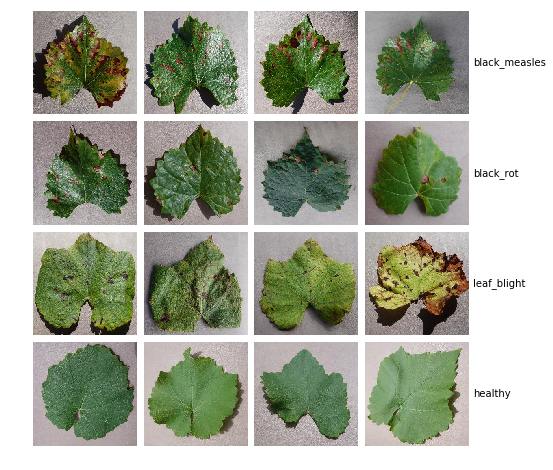

In [137]:
CATEGORIES = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATEGORIES = len(CATEGORIES)
height, width = 256, 256

# Create image grid
fig = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES,NUM_CATEGORIES),
                 axes_pad=0.1) # pad between axes in inch.

# Plot each example image per grid square
i = 0
for category in CATEGORIES:
  for j in range(4):
    ax = grid[i]
    path = os.path.join(data_dir, category)
    file = category + str(j) + '.jpg'
    img = read_img(os.path.join(path, file), size=(height, width))
    ax.imshow(img/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
      ax.text(x=height*1.05, y=height//2, s=category, verticalalignment='center')
    i += 1

fig.show();

We can see some distinctions between the classes (circular black dots for black rot, non-globular brown spots for black measles, etc.). However, most of the images may seem very similar and it is important to observe whether there is a clear distinction between classes. 

### Load Images as Numpy Arrays (OpenCV vs. Keras vs. Pillow)

This step is to load all images into a tensor of Numpy arrays for further processing. However, it was noted that OpenCV produced different orientations for these arrays than Keras and Pillow. This can be observed below.

Comparing OpenCV and Pillow: https://www.kaggle.com/vfdev5/pil-vs-opencv

OpenCv and Pillow imshow different images:
https://stackoverflow.com/questions/49965000/images-opened-in-pillow-and-opencv-are-not-equivelant

https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format

Some notes:
- OpenCV is different than both Keras and Pillow (because BGR format instead of RGB)
- Keras and Pillow are the same
- Keras uses ```tf.keras.preprocessing.image.img_to_array(image_keras)``` to turn into Numpy array
- Pillow uses ```np.array(image)``` to turn into Numpy array
- Keras requires being either cast to uint8 data type (like OpenCV and Pillow) or simply normalized by 255 before using plt.imshow()

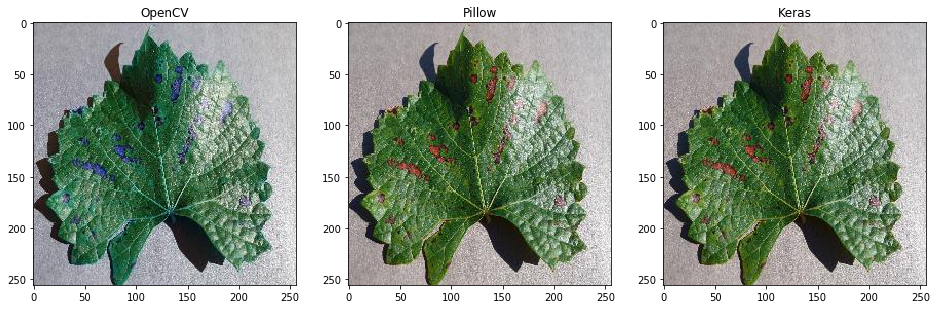

In [138]:
# OpenCV 
image_opencv = cv2.imread(os.path.join(black_measles_dir, 'black_measles1.jpg'))

# Pillow
image_pillow = Image.open(os.path.join(black_measles_dir, 'black_measles1.jpg'))
image_pillow = np.array(image_pillow)

# Keras
image_keras = tf.keras.preprocessing.image.load_img(
                os.path.join(black_measles_dir, 'black_measles1.jpg'))
image_keras = tf.keras.preprocessing.image.img_to_array(image_keras)

pylab.subplot(1, 3, 1);
pylab.title('OpenCV')
plt.imshow(image_opencv);

pylab.subplot(1, 3, 2);
pylab.title('Pillow')
plt.imshow(image_pillow);  # Pillow doesn't need to be normalized

pylab.subplot(1, 3, 3);
pylab.title('Keras')
plt.imshow(image_keras.astype('uint8'));  # Keras needs uint8 or normalized

In [139]:
print('Keras == Pillow:', np.array_equal(image_keras, image_pillow))
print('Keras == OpenCV:', np.array_equal(image_keras, image_opencv))
print('Pillow == OpenCV:', np.array_equal(image_pillow, image_opencv))

Keras == Pillow: True
Keras == OpenCV: False
Pillow == OpenCV: False


We can see that both Keras and Pillow produce the correct image Numpy arrays and that OpenCV does not.

The issue is that OpenCV has different orientations for the color channels (BGR) than Keras/Pillow (RGB). We can simply fix this by reversing the color channel orientation using:

```open_cv_image[:, :, ::-1]```

or 

```cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)```

In [140]:
print('Color channels for OpenCV:', image_opencv[0,0,:])
print('Color channels for Keras:', image_keras[0,0,:])
print('Color channels for Pillow:', image_pillow[0,0,:])

Color channels for OpenCV: [142 142 148]
Color channels for Keras: [148. 142. 142.]
Color channels for Pillow: [148 142 142]


Color channels for OpenCV: [148 142 142]


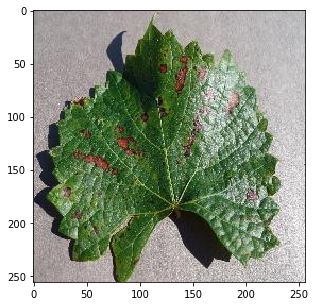

In [141]:
image_opencv_fixed = cv2.cvtColor(image_opencv, cv2.COLOR_BGR2RGB)
print('Color channels for OpenCV:', image_opencv_fixed[0,0,:])
plt.imshow(image_opencv_fixed);

In [0]:
# Black measles Numpy array
black_measles_arr = [read_img(os.path.join(train_black_measles_dir, img), \
                    (256, 256)) for img in os.listdir(train_black_measles_dir)]

# Black rot Numpy array
black_rot_arr = [read_img(os.path.join(train_black_rot_dir, img), \
                 (256, 256)) for img in os.listdir(train_black_rot_dir)]

# Leaf blight Numpy array
leaf_blight_arr = [read_img(os.path.join(train_leaf_blight_dir, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight_dir)]

# Healthy Numpy array
healthy_arr = [read_img(os.path.join(train_healthy_dir, img),\
               (256, 256)) for img in os.listdir(train_healthy_dir)]

# Save Numpy arrays of images
np.save(os.path.join(data_arr_dir, 'black_measles.npy'), arr=black_measles_arr)
np.save(os.path.join(data_arr_dir, 'black_rot.npy'), arr=black_rot_arr)
np.save(os.path.join(data_arr_dir, 'leaf_blight.npy'), arr=leaf_blight_arr)
np.save(os.path.join(data_arr_dir, 'healthy.npy'), arr=healthy_arr)

In [0]:
# Load Numpy arrays of images
black_measles_arr = np.load(os.path.join(data_arr_dir, 'black_measles.npy'))
black_rot_arr = np.load(os.path.join(data_arr_dir, 'black_rot.npy'))
leaf_blight_arr = np.load(os.path.join(data_arr_dir, 'leaf_blight.npy'))
healthy_arr = np.load(os.path.join(data_arr_dir, 'healthy.npy'))

In [0]:
# Reshape arrays
black_measles_arr = black_measles_arr.reshape(886, 256*256*3)
black_rot_arr = black_rot_arr.reshape(756, 256*256*3)
leaf_blight_arr = leaf_blight_arr.reshape(689, 256*256*3)
healthy_arr = healthy_arr.reshape(272, 256*256*3)

### t-Distributed Stochatic Neighbor Embedding (t-SNE)

t-SNE website: https://lvdmaaten.github.io/tsne/  
sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

---

t-SNE is a dimensionality reduction technique that is particularly well suited for the visualization of high-dimensional datasets. It works by converting similarities between data points to join probabilities and tries to minimize the KL divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE is also stochastic, meaning that it may produce different results upon different initializations (non-convex cost function).

Because our input image dimensionality is (256, 256, 3) = 256\*256\*3 = 196,608 dimensions, t-SNE is a good choice to attempt to visualize whether there is a clear distinction between classes. It is recommended to first run a different dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. The purpose of this is to suppress some noise and speed up the computation of pairwise distances between samples. 


In [0]:
def pca(X=np.array([]), no_dims=50):
  """
  Runs PCA on an array X to reduce its dimensoinality to 
  no_dims dimensions.
  @param X - the data matrix to reduce dimensionality
  @param no_dims - the number of dimensions to reduce dimensionality to
  """
  print('Running PCA on the data...')
  mean_vec = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vecs = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vecs = eig_vecs[:, idx]
  Y = np.dot(X, eig_vecs[:, 0:no_dims])
  return Y

def plot_scatter(x, labels):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
  @param X - 2D Numpy array of data reduced to 2-dimensions using t-SNE or PCA
  @param labels - 1D Numpy array of class label strings
  """
  num_classes = len(np.unique(labels))
  color_palette = np.array(sns.color_palette('hls', num_classes))
  f = plt.figure(figsize=(10,10))
  ax = plt.subplot(aspect='equal')
  for i, label in enumerate(np.unique(labels)):
    idx = np.where(labels == label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of Classes in 2D')

In [0]:
# Create the 1D array of class labels
black_measles_lab = np.full(black_measles_arr.shape[0], 'black_measles')
black_rot_lab = np.full(black_rot_arr.shape[0], 'black_rot')
leaf_blight_lab = np.full(leaf_blight_arr.shape[0], 'leaf_blight')
healthy_lab = np.full(healthy_arr.shape[0], 'healthy')

labels = (black_measles_lab, black_rot_lab, leaf_blight_lab, healthy_lab)
labels = np.hstack(labels) 

In [0]:
labels.shape

(2603,)

In [0]:
# Create a stacked array of the training instances 
data_tuple = (black_measles_arr, black_rot_arr, leaf_blight_arr, healthy_arr)
data = np.vstack(tup=data_tuple)/255. # normalize 

In [0]:
data.shape

(2603, 196608)

In [0]:
# Run PCA on data
start = time.time()
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)
end = time.time()

print('Took {:.2f} seconds.'.format(end-start))

Took 38.63 seconds.


In [0]:
data_pca.shape

(2603, 50)

In [0]:
# Run t-SNE on data
start = time.time()
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_pca)
end = time.time()

print('Took {:.2f} seconds'.format(end-start))

Took 19.30 seconds


In [0]:
data_tsne.shape

(2603, 2)

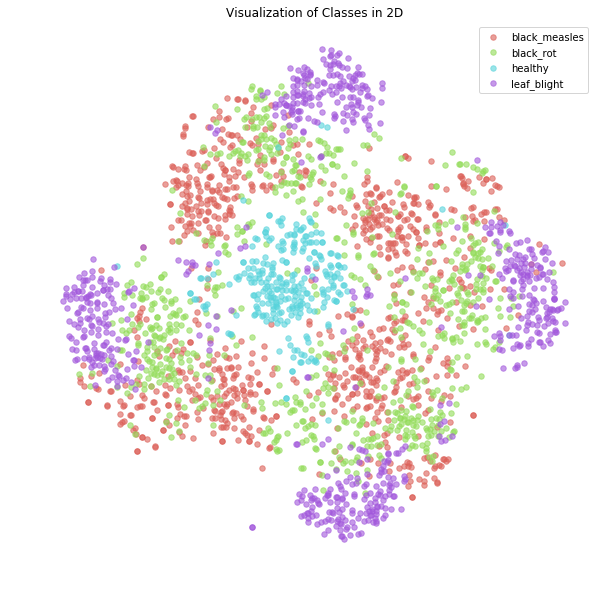

In [0]:
# Visualize the 2D class scatter plot
plot_scatter(data_tsne, labels);

Observing the 2D t-SNE visualization scatter plot we see that the classes have some distinguishing properties. More especially, the healthy leaves are more clusters together in the center, apart from many of the other leaves. However, we also see that the diseases classes (i.e., black measles, black rot, and leaf blight) are clustered in four separate corners of the scatterplot. Although there is a decent clustering in each corner for each disease class, we will see if we are able to correctly classify the images using different CNN architectures. Overall, the visualization is clustered fairly well, especially considering the fact that we are visualizing a 2D representation of our data which came from a 196,608 dimensional feature vector originally.

## Training an Image Classifier

### Helper Functions

In [0]:
def smooth_curve(points, factor=0.8):
  """
  Helper function to help smooth accuracy/loss plots using an exponential
  moving average of the loss and accuracy values. 
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def get_plots(history, smooth=False):
  """
  Helper function to plot training/validation accuracy/loss.
  @param history - Keras model history 
  @param smooth - Boolean for whether to smooth plots or not
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  
  if smooth == True:
    acc = smooth_curve(acc)
    val_acc = smooth_curve(val_acc)
    loss = smooth_curve(loss)
    val_loss = smooth_curve(val_loss)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc,'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def get_metrics(model, generator, steps, target_names=[]):
  """
  Function to print out confusion matrix and classification report.
  """
  target_names = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
  
  # Get predictions for data
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Get confusion matix
  print('Confusion Matrix')
  print(confusion_matrix(y_true=generator.classes, y_pred=y_pred), '\n')
  
  # Get classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=target_names))

### Parameters

In [146]:
img_height, img_width = 256, 256
batch_size = 20
epochs = 30

print('Total number of training examples:', total_train)
print('Total number of validation examples:', total_val)
print('Total number of test examples:', total_test)

Total number of training examples: 2603
Total number of validation examples: 648
Total number of test examples: 811


### Training from Scratch

We will first try and train the model from scratch and observe this as a benchmark.

In [0]:
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

ImageDataGenerator Tutorial: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(img_height, img_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(img_height, img_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.


In [0]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val // batch_size)

Epoch 1/30
131/131 [==============================] - 13s 99ms/step - loss: 0.9421 - acc: 0.5882 - val_loss: 0.7192 - val_acc: 0.6728
Epoch 2/30
131/131 [==============================] - 13s 96ms/step - loss: 0.4429 - acc: 0.8337 - val_loss: 0.3303 - val_acc: 0.8750
Epoch 3/30
131/131 [==============================] - 13s 95ms/step - loss: 0.2918 - acc: 0.8836 - val_loss: 0.1852 - val_acc: 0.9306
Epoch 4/30
131/131 [==============================] - 12s 95ms/step - loss: 0.1443 - acc: 0.9489 - val_loss: 0.1148 - val_acc: 0.9599
Epoch 5/30
131/131 [==============================] - 13s 96ms/step - loss: 0.0949 - acc: 0.9666 - val_loss: 0.1109 - val_acc: 0.9645
Epoch 6/30
131/131 [==============================] - 13s 99ms/step - loss: 0.0588 - acc: 0.9785 - val_loss: 0.1361 - val_acc: 0.9614
Epoch 7/30
131/131 [==============================] - 13s 101ms/step - loss: 0.0455 - acc: 0.9842 - val_loss: 0.0886 - val_acc: 0.9722
Epoch 8/30
131/131 [==============================] - 13s 96m

In [0]:
model.save(os.path.join(model_dir, 'disease-scratch.h5'))

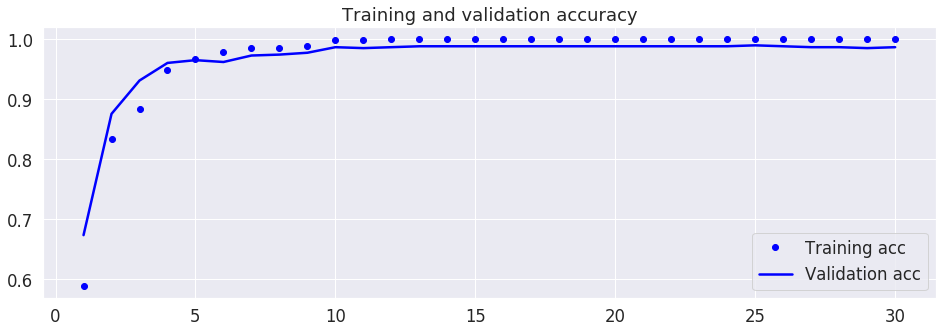

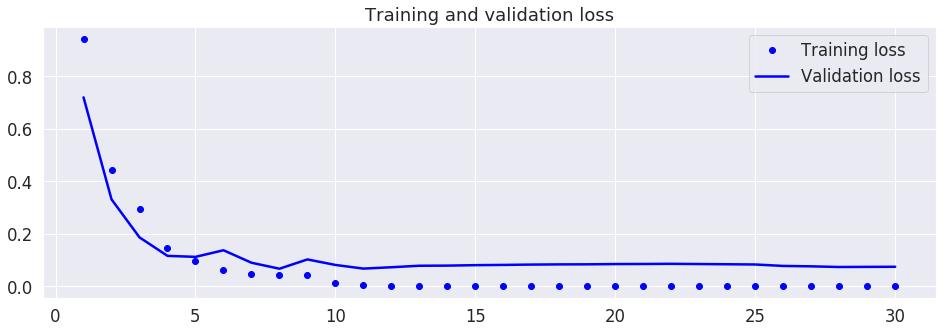

In [0]:
get_plots(history)

We see that training from scratch yielded pretty high results in terms of accuracy. However, since we are dealing with an imbalanced dataset, accuracy may not be a great metric to use. In that case, we will plot a confusion matrix and observe the precision, accuracy, and F1-score of our classifier. 

For this case, we need to construct another data generator for the validation data evaluation. It is important to set shuffle to False so that the data can be properly compared to the class probabilities by ```predict_generator``` in the correct order.   

In [0]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


In [0]:
# Observe the classes
val_test_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Confusion matrix is in the format:

|  | Predicted |  |  |  |  |
| - | - | - | - | - | - |
| **True** | black_measles | black_rot | leaf_blight | healthy | 
| black_measles | 
| black_rot | 
| leaf_blight |
| healthy | 

In [0]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-scratch.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

Confusion Matrix
[[220   1   0   0]
 [  0 181   1   6]
 [  0   0  67   0]
 [  0   1   0 171]] 

Classification Report
               precision    recall  f1-score   support

black_measles       1.00      1.00      1.00       221
    black_rot       0.99      0.96      0.98       188
  leaf_blight       0.99      1.00      0.99        67
      healthy       0.97      0.99      0.98       172

    micro avg       0.99      0.99      0.99       648
    macro avg       0.99      0.99      0.99       648
 weighted avg       0.99      0.99      0.99       648



### Transfer Learning

It is usually best practice to reuse a pre-trained model trained on a larger dataset, especially when dealing with a limited dataset. This pre-trained model's convolutional base can be reused and fine-tuned to achieve better performance. Typically this works well if the pre-trained model was trained on a dataset with similar images to the new dataset. Early layers in the convolutional base have learned useful low-level features that usually generalizes well as feature extractors. However, the upper layers typically are more class-specific and high-level and may not be as useful for a different dataset. In that case, some fine-tuning can be done after the model is trained on the new dataset. The higher layers of the convolutional base can be unfrozen and retrained after the fully-connected layers are trained. You typically do not want to unfreeze the upper layers of the convolutional base with randomly initialized fully-connected classifier layers because the error that propagates will essentially destroy all meaningful feature information learned in the convolutional base. Also, the learning rate for the fine-tuned layers should be much lower so we don't distort the weights too much, because the weights for those layers are assumed to already be pretty good already.

In addition to transfer learning, this model will incorporate data augmentation and dropout as a means of regularization and a means of reducing overfitting. In addition, data augmentation will essentially allow our model to be more robust to slight variances in the images and essentially have more synthesized training data. 

Some pretrained models on ImageNet that Keras offers can be found in the ```keras.applications``` module. Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.  

https://keras.io/applications/

- Xception
- VGG16
- VGG19
- ResNet, ResNetV2, ResNeXt
- InceptionV3
- InceptionResNetV2
- MobileNet
- MobileNetV2
- DenseNet
- NASNet

Weights are downloaded automatically when instantiating a model. They are stored at ```~/.keras/models/```. 

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_height, img_width, 3))

In [76]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [77]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 23,104,580
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Freeze convolutional base
print('Trainable weights before freezing:', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing:', len(model.trainable_weights))

Trainable weights before freezing: 30
Trainable weights after freezing: 4


In [79]:
# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# No data augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(img_height, img_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(img_height, img_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.


In [0]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train//batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val//batch_size)

Epoch 1/30
131/131 [==============================] - 706s 5s/step - loss: 1.5181 - acc: 0.6892 - val_loss: 0.3463 - val_acc: 0.8657
Epoch 2/30
131/131 [==============================] - 45s 345ms/step - loss: 0.4219 - acc: 0.8191 - val_loss: 0.2372 - val_acc: 0.9367
Epoch 3/30
131/131 [==============================] - 47s 358ms/step - loss: 0.3698 - acc: 0.8459 - val_loss: 0.1942 - val_acc: 0.9429
Epoch 4/30
131/131 [==============================] - 45s 347ms/step - loss: 0.3406 - acc: 0.8652 - val_loss: 0.2119 - val_acc: 0.9228
Epoch 5/30
131/131 [==============================] - 46s 347ms/step - loss: 0.3068 - acc: 0.8778 - val_loss: 0.1723 - val_acc: 0.9259
Epoch 6/30
131/131 [==============================] - 44s 336ms/step - loss: 0.2774 - acc: 0.8920 - val_loss: 0.1517 - val_acc: 0.9491
Epoch 7/30
131/131 [==============================] - 46s 348ms/step - loss: 0.2639 - acc: 0.8932 - val_loss: 0.1241 - val_acc: 0.9537
Epoch 8/30
131/131 [==============================] - 45s

In [0]:
model.save(os.path.join(model_dir, 'disease-tl.h5'))

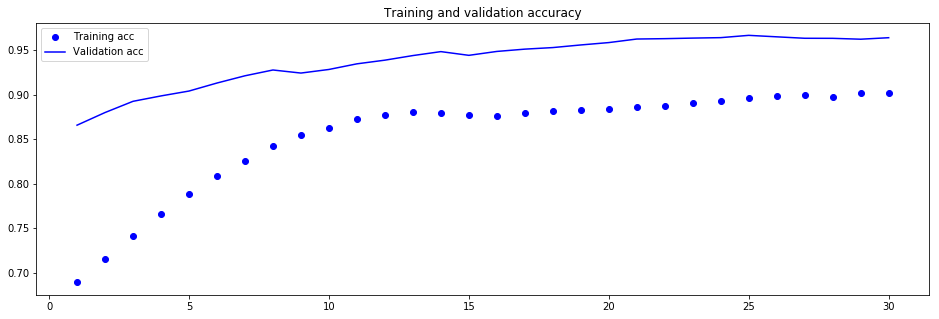

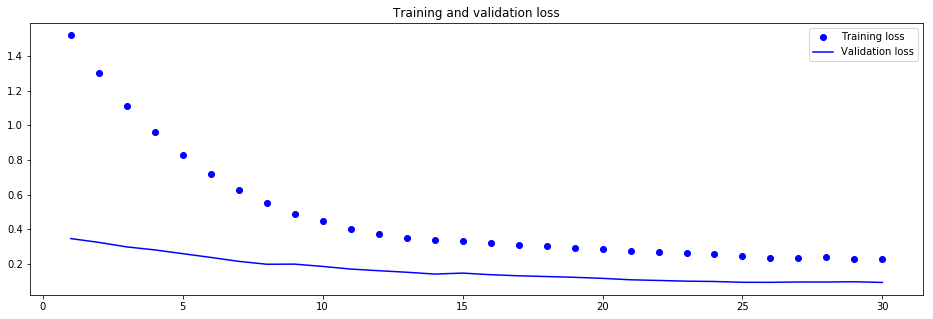

In [0]:
get_plots(history, smooth=True)

In [80]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


In [81]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

Confusion Matrix
[[212   9   0   0]
 [ 10 178   0   0]
 [  0   0  67   0]
 [  0   0   0 172]] 

Classification Report
               precision    recall  f1-score   support

black_measles       0.95      0.96      0.96       221
    black_rot       0.95      0.95      0.95       188
  leaf_blight       1.00      1.00      1.00        67
      healthy       1.00      1.00      1.00       172

    micro avg       0.97      0.97      0.97       648
    macro avg       0.98      0.98      0.98       648
 weighted avg       0.97      0.97      0.97       648



### Fine-Tune Model

After training the upper fully-connected layers on our dataset, we can unfreeze the upper layers of the convolutional base and fine-tune the model. This step should only be done after training the fully-connected layers on our dataset first. This is so that the error propagating back to the convolutional base is not too large in which it destroys the representation already learned in the upper layers. In addition, a smaller learning rate should be used to make smaller, more conservative changes to the weight updates. 

In [82]:
conv_base.layers

In [83]:
conv_base.layers[0].name

'input_2'

In [0]:
# Fine-tune convolutional block 5

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# Compile the model and use a smaller learning rate for optimizer
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val // batch_size)

Epoch 1/30
131/131 [==============================] - 904s 7s/step - loss: 0.5882 - acc: 0.7610 - val_loss: 0.1978 - val_acc: 0.9244
Epoch 2/30
131/131 [==============================] - 47s 359ms/step - loss: 0.1926 - acc: 0.9270 - val_loss: 0.0881 - val_acc: 0.9722
Epoch 3/30
131/131 [==============================] - 49s 372ms/step - loss: 0.1159 - acc: 0.9593 - val_loss: 0.0521 - val_acc: 0.9830
Epoch 4/30
131/131 [==============================] - 47s 362ms/step - loss: 0.0888 - acc: 0.9704 - val_loss: 0.0481 - val_acc: 0.9815
Epoch 5/30
131/131 [==============================] - 48s 364ms/step - loss: 0.0597 - acc: 0.9781 - val_loss: 0.0342 - val_acc: 0.9877
Epoch 6/30
131/131 [==============================] - 49s 371ms/step - loss: 0.0545 - acc: 0.9781 - val_loss: 0.0242 - val_acc: 0.9892
Epoch 7/30
131/131 [==============================] - 48s 364ms/step - loss: 0.0428 - acc: 0.9869 - val_loss: 0.0306 - val_acc: 0.9892
Epoch 8/30
131/131 [==============================] - 49s

In [0]:
model.save(os.path.join(model_dir, 'disease-tl-ft.h5'))

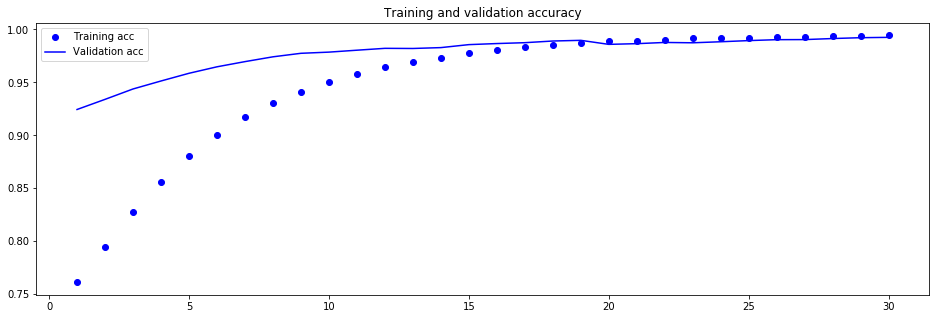

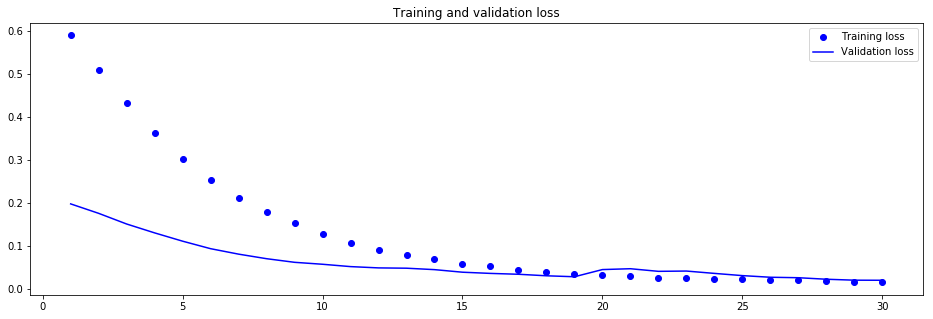

In [0]:
get_plots(history, smooth=True)

In [86]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


In [87]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl-ft.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

Confusion Matrix
[[221   0   0   0]
 [  4 184   0   0]
 [  0   0  67   0]
 [  0   0   0 172]] 

Classification Report
               precision    recall  f1-score   support

black_measles       0.98      1.00      0.99       221
    black_rot       1.00      0.98      0.99       188
  leaf_blight       1.00      1.00      1.00        67
      healthy       1.00      1.00      1.00       172

    micro avg       0.99      0.99      0.99       648
    macro avg       1.00      0.99      1.00       648
 weighted avg       0.99      0.99      0.99       648



We can see that by applying several methods to increase performance of our model (i.e., transfer learning, data augmentation, dropout) we were able to obtain 100% accuracy, and a F1-score between 0.99-1.00 on our validation data. However, let's see how well our model generalizes to unseen data, more specifically to our test dataset that was held out. 

### Final Model Evaluation on Test Data

In [88]:
# Create the new validation generator for test/evaluation
test_gen = test_datagen.flow_from_directory(
                test_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 811 images belonging to 4 classes.


In [89]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl-ft.h5'))


# Get confusion matrix and classification report
get_metrics(model, generator=test_gen, steps=total_test)

Confusion Matrix
[[276   0   0   0]
 [  3 233   0   0]
 [  0   0  84   0]
 [  0   0   0 215]] 

Classification Report
               precision    recall  f1-score   support

black_measles       0.99      1.00      0.99       276
    black_rot       1.00      0.99      0.99       236
  leaf_blight       1.00      1.00      1.00        84
      healthy       1.00      1.00      1.00       215

    micro avg       1.00      1.00      1.00       811
    macro avg       1.00      1.00      1.00       811
 weighted avg       1.00      1.00      1.00       811



In [90]:
# Find the images that were misclassified
y_pred = model.predict_generator(generator=test_gen, steps=total_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Indices where misclassified
idx = np.where(np.not_equal(y_pred, y_true))
idx

(array([326, 451, 502]),)

We see that the images indexes at 326, 451, and 502 were the black_rot images misclassified as black_measles. We can use ```test_gen.filepaths``` to get the paths to those images and find the filepaths for those specific images.

In [91]:
filepaths = [test_gen.filepaths[i] for i in idx[0]]
filepaths

['./data/test/black_rot/black_rot207.jpg',
 './data/test/black_rot/black_rot697.jpg',
 './data/test/black_rot/black_rot948.jpg']

Text(0.5, 1.0, 'black_rot207.jpg')

Text(0.5, 1.0, 'black_rot697.jpg')

Text(0.5, 1.0, 'black_rot948.jpg')

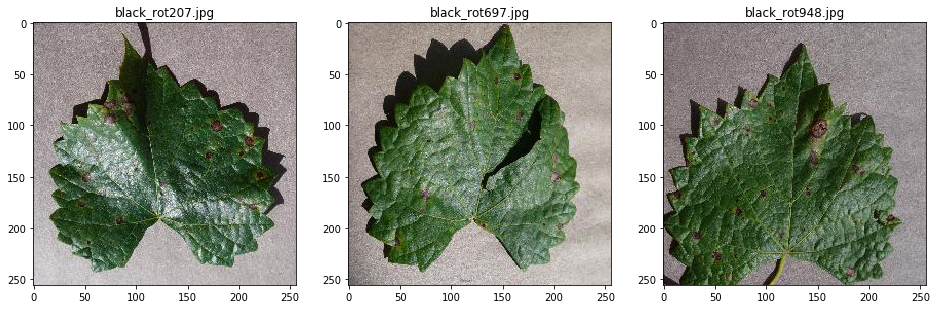

In [92]:
f = plt.figure()
for i, file in enumerate(filepaths):
  f.add_subplot(1, len(filepaths), i+1)
  img = read_img(filepath=file, size=(256,256))
  plt.title(file.rsplit('/')[-1])
  plt.imshow(img/255.)

After observing these misclassified samples, we are able to understand why the model was not able to correctly classify them as black rot. For my perspective, they seem very subtle and the brown/black spots are not as noticeable and blend in with the rest of the leaf. Also it seems as if the disease is at a relatively early stage and not as easily distinguished. 